In [2]:
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [3]:
# {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

this_building = 1176
this_meter = 1

In [4]:
df_meters = pd.read_csv('../../../data/raw/csvs/train.csv', parse_dates=['timestamp'])

not_this_building = (df_meters[df_meters['building_id'] != this_building]).index.to_list()
df_meters.drop(not_this_building, axis=0, inplace=True)
df_meters.drop('building_id', axis=1, inplace=True)

not_this_meter = (df_meters[df_meters['meter'] != this_meter]).index.to_list()
df_meters.drop(not_this_meter, axis=0, inplace=True)
df_meters.drop('meter', axis=1, inplace=True)

df_meters.set_index('timestamp', inplace=True)

df_meters.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 1 columns):
meter_reading    8784 non-null float64
dtypes: float64(1)
memory usage: 137.2 KB


In [5]:
# Building metadata
bdata = pd.read_csv('../../../data/raw/csvs/building_metadata.csv', index_col='building_id')
this_site = bdata.loc[this_building]['site_id'] 
bdata.loc[this_building]

site_id               13
primary_use    Education
square_feet       142672
year_built           NaN
floor_count          NaN
Name: 1176, dtype: object

In [6]:
df_weather = pd.read_csv('../../../data/raw/csvs/weather_train.csv', parse_dates=['timestamp'])

not_this_site = (df_weather[df_weather['site_id'] != this_site]).index.to_list()
df_weather.drop(not_this_site, axis=0, inplace=True)
df_weather.drop('site_id', axis=1, inplace=True)

df_weather.set_index('timestamp', inplace=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 7 columns):
air_temperature       8782 non-null float64
cloud_coverage        4485 non-null float64
dew_temperature       8782 non-null float64
precip_depth_1_hr     8771 non-null float64
sea_level_pressure    8663 non-null float64
wind_direction        8566 non-null float64
wind_speed            8782 non-null float64
dtypes: float64(7)
memory usage: 548.9 KB


<b>Let's visualise data with timeseries plots.<b>

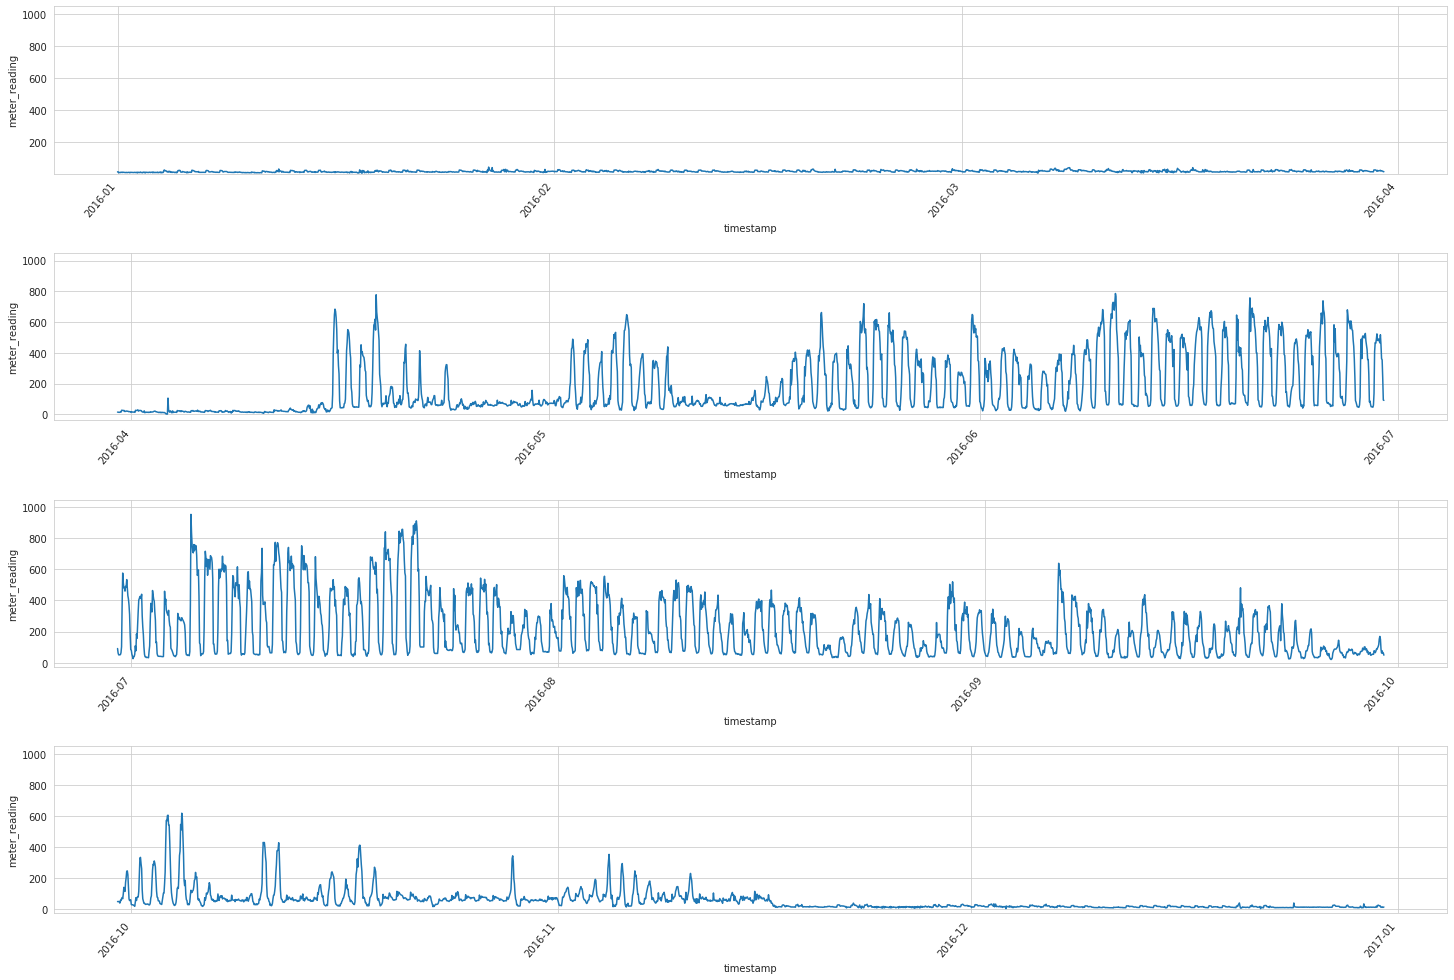

In [7]:
# Plot 'meter_reading' only on 4*3 months

date_range = pd.date_range(
    start=df_meters.index.min()-pd.Timedelta('1 days'), 
    end=df_meters.index.max()+pd.Timedelta('1 days'), 
    freq='3M'
)

spread = df_meters['meter_reading'].max() - df_meters['meter_reading'].min()
top = df_meters['meter_reading'].max() + 0.1 * spread

fig = plt.figure(figsize=(20, 8*date_range.shape[0]))
    
with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        ax = sns.lineplot(x="timestamp", y="meter_reading",
        data=df_meters.loc[date_range[i]:date_range[i+1]].reset_index(inplace=False))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.set_ylim(top=top)
        plt.xticks(rotation=50, horizontalalignment='right')
        
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)

Add weather data

https://matplotlib.org/tutorials/intermediate/gridspec.html

In [8]:
# Prepare 'meter_reading' data

meter_names = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

df_meters_w_name = df_meters.copy()
df_meters_w_name['meter_type'] = meter_names.get(this_meter)

mr_spread = df_meters['meter_reading'].max() - df_meters['meter_reading'].min()
mr_top = df_meters['meter_reading'].max() + 0.1 * mr_spread


# ---
# Prepare 'sea_level_pressure' and 'precip_depth_1_hr' data

df_pp = df_weather[['precip_depth_1_hr', 'sea_level_pressure']].copy()

# Project slp on [0, 2]
slp_max = df_pp['sea_level_pressure'].max()
slp_min = df_pp['sea_level_pressure'].min()
slp_mean = df_pp['sea_level_pressure'].mean()
slp_spread = slp_max - slp_min
df_pp['sea_level_pressure'] = 1 + (df_pp['sea_level_pressure'] - slp_mean) / slp_spread
df_pp['mean_sea_level_pressure'] = 1

pd1h_max = df_pp['precip_depth_1_hr'].max()
df_pp['precip_depth_1_hr'] = 1.5 * df_pp['precip_depth_1_hr'] / pd1h_max

df_melted_pp = pd.melt(df_pp.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='variable', value_name = 'value')

df_melted_pp.set_index('timestamp', inplace=True)
df_melted_pp.sort_index(inplace=True)


# ---
# Prepare 'air_temperature' and 'dew_temperature' data

df_temperatures_scaled = df_weather[['air_temperature', 'dew_temperature']].copy()
max_T = df_temperatures_scaled.max().max()
min_T = df_temperatures_scaled.min().min()
scaling_factor_T = max(max_T, abs(min_T))

df_melted_temperatures = pd.melt(df_temperatures_scaled.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='variable', value_name = 'value')

df_melted_temperatures.set_index('timestamp', inplace=True)
df_melted_temperatures.sort_index(inplace=True)

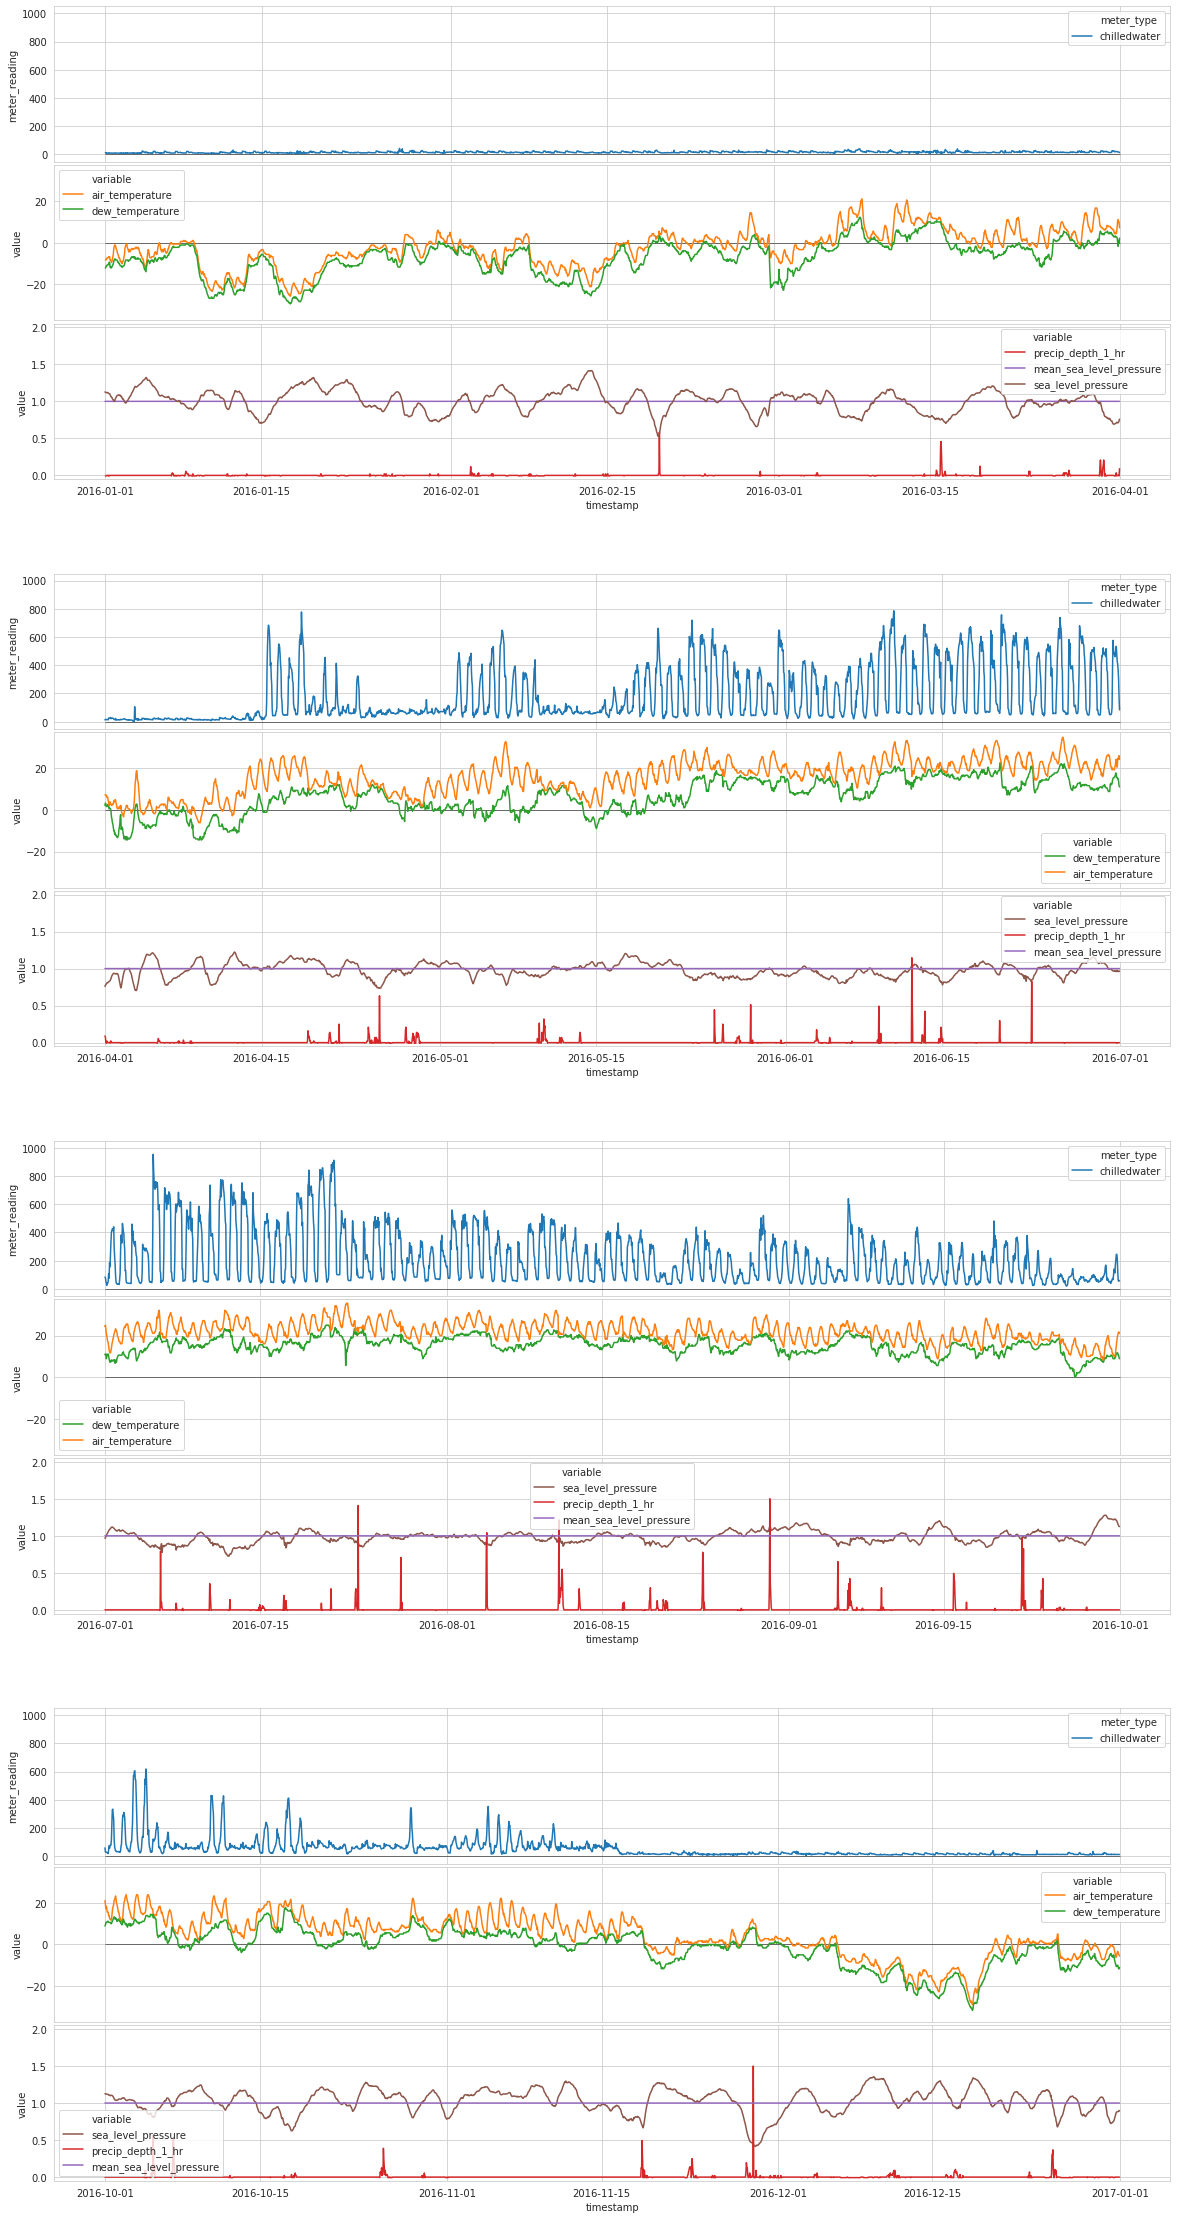

In [9]:
# Plot on 4*3 months

date_range = pd.date_range(
    start=df_meters.index.min()-pd.Timedelta('1 hours'), 
    end=df_meters.index.max(), 
    freq='3M'
)

n_major_subplots = date_range.shape[0]-1

# Build common palette for all subplots
meter_ax_variables = df_meters_w_name['meter_type'].unique().tolist()
temperatures_ax_variables = df_melted_temperatures['variable'].unique().tolist()
pp_ax_variables = df_melted_pp['variable'].unique().tolist()
all_variables = meter_ax_variables + temperatures_ax_variables + pp_ax_variables
common_palette = dict(zip(all_variables, sns.color_palette()))

fig = plt.figure(figsize=(20, 10*n_major_subplots), constrained_layout=False)
gs0 = fig.add_gridspec(nrows=n_major_subplots, ncols=1)
    
    
with sns.axes_style("whitegrid"):
    for i in range(n_major_subplots):
        
        # Organize subplot dispatching
        gs0i = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs0[i], hspace=0.02)
        meter_ax = fig.add_subplot(gs0i[0])
        temperatures_ax = fig.add_subplot(gs0i[1])
        pp_ax = fig.add_subplot(gs0i[2])
        
        sns.lineplot(
            x="timestamp", 
            y="meter_reading",
            hue="meter_type",
            data=df_meters_w_name.loc[date_range[i]:date_range[i+1]].reset_index(inplace=False),
            palette=common_palette,
            ax=meter_ax
        )
                                          
        sns.lineplot(
            x="timestamp", 
            y="value",
            hue="variable",
            data=df_melted_temperatures.loc[date_range[i]:date_range[i+1]].reset_index(inplace=False),
            palette=common_palette,
            ax=temperatures_ax
        )
        
        sns.lineplot(
            x="timestamp", 
            y="value",
            hue="variable",
            data=df_melted_pp.loc[date_range[i]:date_range[i+1]].reset_index(inplace=False),
            palette=common_palette,
            ax=pp_ax
        )
        
        meter_ax.hlines(y=0, xmin=date_range[i], xmax=date_range[i+1], linewidth=.5, color='k')
        meter_ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        meter_ax.set_xlabel("")
        meter_ax.set_ylim(bottom=-.05*top, top=mr_top)
        
        temperatures_ax.hlines(y=0, xmin=date_range[i], xmax=date_range[i+1], linewidth=.5, color='k')
        temperatures_ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        temperatures_ax.set_xlabel("")
        temperatures_ax.set_ylim(bottom=-1.05*scaling_factor_T, top=1.05*scaling_factor_T)
        
        pp_ax.set_ylim(bottom=-.05, top=2.05)
        
        #plt.xticks(rotation=50, horizontalalignment='right')

<b>Visualise data with scatter plots.<b>

Let's study meter_reading vs weather, and time ;<br>
meter_reading is periodical, so we can begin by plotting meter_reading vs hour/minute  

In [10]:
df_features = df_meters.join(df_weather, on='timestamp', how='left')
df_features.head()

,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,13.6612,-8.3,8.0,-12.2,NaN,1023.3,250.0,4.1
2016-01-01 01:00:00,13.6612,-8.3,NaN,-11.7,-1.0,1023.3,240.0,4.1
2016-01-01 02:00:00,7.4970,-7.8,NaN,-11.1,-1.0,1022.9,240.0,3.1
2016-01-01 03:00:00,9.8294,-7.8,NaN,-11.1,-1.0,1022.7,250.0,4.1
2016-01-01 04:00:00,9.6628,-7.2,NaN,-10.6,0.0,1022.8,270.0,4.1


In [11]:
df_weather.head()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,
2016-01-01 00:00:00,-8.3,8.0,-12.2,NaN,1023.3,250.0,4.1
2016-01-01 01:00:00,-8.3,NaN,-11.7,-1.0,1023.3,240.0,4.1
2016-01-01 02:00:00,-7.8,NaN,-11.1,-1.0,1022.9,240.0,3.1
2016-01-01 03:00:00,-7.8,NaN,-11.1,-1.0,1022.7,250.0,4.1
2016-01-01 04:00:00,-7.2,NaN,-10.6,0.0,1022.8,270.0,4.1


In [12]:
df_weather['air_temperature'].head()

timestamp
2016-01-01 00:00:00   -8.3
2016-01-01 01:00:00   -8.3
2016-01-01 02:00:00   -7.8
2016-01-01 03:00:00   -7.8
2016-01-01 04:00:00   -7.2
Name: air_temperature, dtype: float64

In [13]:
# plot meter_reading vs air temperature

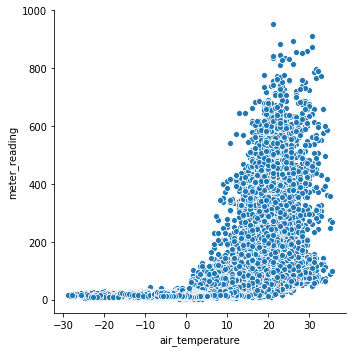

In [14]:
sns.relplot(x="air_temperature", y="meter_reading", data=df_features);

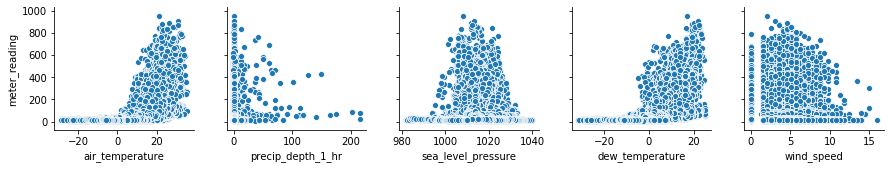

In [15]:
sns.pairplot(data=df_features, x_vars=['air_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'dew_temperature', 'wind_speed'],
             y_vars=['meter_reading'])

In [25]:
# Add some time features.

df_features['day_hour'] = df_features.index.to_series().dt.hour

# Add feature day of week because for some buildings like schools,
# energy consumption is less important on week-ends.
df_features['day_of_week'] = df_features.index.to_series().dt.dayofweek

In [17]:
df_features.head()

,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_hour
timestamp,,,,,,,,,
2016-01-01 00:00:00,13.6612,-8.3,8.0,-12.2,NaN,1023.3,250.0,4.1,0
2016-01-01 01:00:00,13.6612,-8.3,NaN,-11.7,-1.0,1023.3,240.0,4.1,1
2016-01-01 02:00:00,7.4970,-7.8,NaN,-11.1,-1.0,1022.9,240.0,3.1,2
2016-01-01 03:00:00,9.8294,-7.8,NaN,-11.1,-1.0,1022.7,250.0,4.1,3
2016-01-01 04:00:00,9.6628,-7.2,NaN,-10.6,0.0,1022.8,270.0,4.1,4


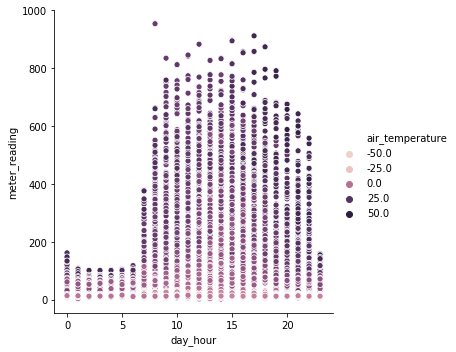

In [18]:
sns.relplot(x="day_hour", y="meter_reading", hue="air_temperature", data=df_features);

In [19]:
# TODO 
# Tracer m_reading-tendance = f(day_hour) 

In [20]:
df_elec.head()

NameError: name 'df_elec' is not defined

In [ ]:
do_center = False
df_elec['daily_mean_temp'] = df_elec['air_temperature'].rolling(24, center=do_center).mean()
df_elec['three_day_mean_temp'] = df_elec['air_temperature'].rolling(3*24, center=do_center).mean()
df_elec['weekly_mean_temp'] = df_elec['air_temperature'].rolling(7*24, center=do_center).mean()
df_elec.head()

In [ ]:
df_tick = df_elec['air_temperature'].reset_index()
df_daily = df_elec['daily_mean_temp'].reset_index()
df_3d = df_elec['three_day_mean_temp'].reset_index()
df_weekly = df_elec['weekly_mean_temp'].reset_index()

In [ ]:
df_tick['timeframe'] = 'tick'
df_daily['timeframe'] = 'daily_mean'
df_3d['timeframe'] = 'three_day_mean'
df_weekly['timeframe'] = 'weekly_mean'

In [ ]:
df_daily.head()

In [ ]:
rename_temp = lambda df : df.rename(columns={df.columns[1]:'air_temperature'}, inplace=True)

rename_temp(df_tick)
rename_temp(df_daily)
rename_temp(df_3d)
rename_temp(df_weekly)


df_temp = pd.concat([df_tick, df_daily, df_3d, df_weekly], axis=0)
df_temp.shape

In [ ]:
date_range = pd.date_range(start=df_meters_cat.index.min()-pd.Timedelta('1 days'), 
                           end=df_meters_cat.index.max(), freq='1M')
start_date = date_range[1]
end_date = date_range[2]
data = df_temp[(df_temp['timestamp'] > start_date) & (df_temp['timestamp'] <= end_date)]
data.head()

In [ ]:
# Plot air_temperature centered MA month by months

df_meters_ws = df_meters_cat[df_meters_cat['meter'] != 'steam']

date_range = pd.date_range(start=df_meters_cat.index.min()-pd.Timedelta('1 days'), 
                           end=df_meters_cat.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = df_temp[(df_temp['timestamp'] > start_date) & (df_temp['timestamp'] <= end_date)]
        ax = sns.lineplot(x="timestamp", y="air_temperature", hue="timeframe", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

In [ ]:
df_elec.head()

In [ ]:
 # Let's compute meter_reading daily and 3 day centered MA
do_center = False
df_elec['reading_mean_1d'] = df_elec['meter_reading'].rolling(24, center=do_center).mean()
df_elec['reading_mean_3d'] = df_elec['meter_reading'].rolling(3*24, center=do_center).mean()

In [ ]:
df_elec.head()

In [ ]:
sns.pairplot(data=df_elec, x_vars=['day_hour', 'day_of_year', 'air_temperature', 'daily_mean_temp', 'three_day_mean_temp'],
             y_vars=['meter_reading', 'reading_mean_1d', 'reading_mean_3d'])

In [ ]:
# no clear relationship
sns.relplot(x="daily_mean_temp", y="reading_mean_1d", data=df_elec);

In [ ]:
sns.relplot(x="day_of_year", y="reading_mean_1d", data=df_elec);

The meters reading have a periodic component and a mean value component.
We want to see which features meteorological features have an impact on the mean value component.
Hence we are going to build clean features from meteorological data, and compute correlations/chi squared against 1day/3days mean meter_readings.

Memo : "The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features."

In [ ]:
df_weather.head()

In [ ]:
# The only feature with lot's of NaN is 'cloud_coverage'
df_weather.info()

In [ ]:
# NaNs does not replace 0.
df_weather['cloud_coverage'].value_counts()

Wikipedia :<br>
Sky conditions are estimated in terms of how many eighths of the sky are covered in cloud, ranging from 0 oktas (completely clear sky) through to 8 oktas (completely overcast). In addition, in the SYNOP code there is an extra cloud cover indicator '9' indicating that the sky is totally obscured (i.e. hidden from view), usually due to dense fog or heavy snow. 

In [ ]:
heat_cloud = df_weather[['cloud_coverage']].copy()
heat_cloud.head()

In [ ]:
heat_cloud['month'] = heat_cloud.index.to_series().dt.month
heat_cloud.head()

In [ ]:
heat_cloud['month_day'] = heat_cloud.index.to_series().dt.day
heat_cloud.head()

In [ ]:
heat_cloud['hour'] = heat_cloud.index.to_series().dt.hour
heat_cloud.head()

In [ ]:
heat_cloud.reset_index(inplace=True)
heat_cloud.head()

In [ ]:
heat_cloud_uni = heat_cloud.drop(['timestamp'], axis=1, inplace=False)
heat_cloud_uni.head()

In [ ]:
heat_cloud_p = pd.pivot_table(data=heat_cloud_uni, values='cloud_coverage',
                              index=['month_day', 'hour'], columns='month')
heat_cloud_p.shape

In [ ]:
# TODOS pr rendre la heatmap un peu plus cool :
# - faire une colonne par week name w1..w52 et day_of_week,hour
# - colorer les Nans.
# - remettre la cbar dans une taille mieux

# A faire plus tard, avancer sur les correlations en droppant 'heat_cloud'

In [ ]:
#fig = plt.figure(figsize=(5, 300))
#sns.heatmap(heat_cloud_p, cmap="YlGnBu", square=True, cbar=False)

In [21]:
df_weather.head()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,
2016-01-01 00:00:00,-8.3,8.0,-12.2,NaN,1023.3,250.0,4.1
2016-01-01 01:00:00,-8.3,NaN,-11.7,-1.0,1023.3,240.0,4.1
2016-01-01 02:00:00,-7.8,NaN,-11.1,-1.0,1022.9,240.0,3.1
2016-01-01 03:00:00,-7.8,NaN,-11.1,-1.0,1022.7,250.0,4.1
2016-01-01 04:00:00,-7.2,NaN,-10.6,0.0,1022.8,270.0,4.1


In [26]:
df_features.head()

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_hour,day_of_week
timestamp,,,,,,,,,
2016-01-01 00:00:00,13.6612,-8.3,-12.2,NaN,1023.3,250.0,4.1,0,4
2016-01-01 01:00:00,13.6612,-8.3,-11.7,-1.0,1023.3,240.0,4.1,1,4
2016-01-01 02:00:00,7.4970,-7.8,-11.1,-1.0,1022.9,240.0,3.1,2,4
2016-01-01 03:00:00,9.8294,-7.8,-11.1,-1.0,1022.7,250.0,4.1,3,4
2016-01-01 04:00:00,9.6628,-7.2,-10.6,0.0,1022.8,270.0,4.1,4,4


In [24]:
df_features.drop('cloud_coverage', axis=1, inplace=True)

In [27]:
# Lets compute mean consumption = f(day)
df_features[['meter_reading', 'day_of_week']].groupby(['day_of_week']).mean()

,meter_reading
day_of_week,
0,137.335398
1,137.742693
2,129.930382
3,123.110322
4,117.253396
5,89.062366
6,86.589415


In [ ]:
(120-90)/120*100

Effectively, energy consumption is 25% less important on week-ends than during week.<br>
Hence day_of_week looks like an interesting feature.

For each meteorological data, we are going to test three features : raw data and moving_average on one day and three days.<br>
Note that for wind direction, as it is angular data, computing a moving average does not have a sense (average of 359 degree and 1 degree is 180 degrees, which is the inverse direction). We could compute an average with a fine-tuned computation, but for the moment let's only use raw value for this feature.<br>
Note : add also short-term MA, 4 hours.


Another idea is to add lagged timeseries. Question is : which lags might be interesting ? adding lots of lags might be cumbersome.<br>
We could test : 1h, 2h, 5h, 10h for instance.

We also need to computer a moving average (trend) on meter_reading.<br>
First, let's compute auto-correlation to confirm the one-day seasonnality, and potentially detect other seasonalities.

In [28]:
x_mr = df_features['meter_reading']
acf(x=x_mr, fft=True)

array([1.        , 0.957949  , 0.89215567, 0.81002173, 0.71758237,
       0.62263223, 0.52652074, 0.43319585, 0.34583346, 0.2700867 ,
       0.21470756, 0.17840704, 0.16380779, 0.1729262 , 0.20166926,
       0.24842981, 0.31705639, 0.39801354, 0.48498189, 0.57382005,
       0.66089991, 0.73995039, 0.80517253, 0.85111973, 0.86793989,
       0.84163699, 0.78955094, 0.71912796, 0.63810371, 0.55204021,
       0.46525691, 0.38081409, 0.29990151, 0.22915259, 0.17265714,
       0.13464227, 0.1219865 , 0.13218497, 0.16381246, 0.21369019,
       0.28058033])

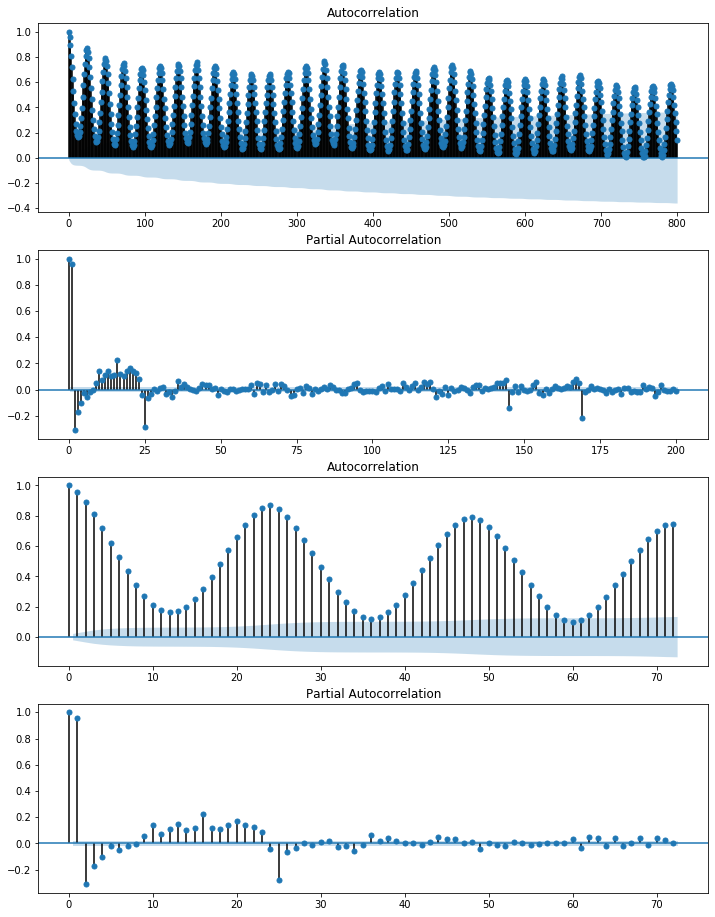

In [29]:
# Autocorrelation (note that x-tick is in hours).
# We observe two seasonalities : a strong one day seasonality, and a one week seasonality 
# (higher autocorreletion peak every 7 days).
# The one week seasonality will be adressed by the day_of_week feature
fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(411)
fig = sm.graphics.tsa.plot_acf(x_mr, lags=800, ax=ax1)
ax2 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_pacf(x_mr, lags=200, ax=ax2)
ax3 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_acf(x_mr, lags=24*3, ax=ax3)
ax4 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_pacf(x_mr, lags=24*3, ax=ax4)

In [42]:
# Compute variable to predict : meter_reading trend
# Two possible models : additive and multiplicative.
# Two-sided.

# seasonal, trend, resid
res = seasonal_decompose(x_mr.asfreq('1H', method='ffill'), model='additive', two_sided=True)
res_dict = {'meter_reading' : x_mr, 'trend' : res.trend, 'seasonal' : res.seasonal, 'residual' : res.resid}
res_as_df = pd.DataFrame(res_dict)
res_as_df.head()

,meter_reading,trend,seasonal,residual
timestamp,,,,
2016-01-01 00:00:00,13.6612,NaN,-71.449447,NaN
2016-01-01 01:00:00,13.6612,NaN,-78.338225,NaN
2016-01-01 02:00:00,7.4970,NaN,-82.211341,NaN
2016-01-01 03:00:00,9.8294,NaN,-82.716029,NaN
2016-01-01 04:00:00,9.6628,NaN,-82.308714,NaN


In [43]:
df_decomposed_readings = pd.melt(res_as_df.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')
df_decomposed_readings.head()

,timestamp,component,reading
0,2016-01-01 00:00:00,meter_reading,13.6612
1,2016-01-01 01:00:00,meter_reading,13.6612
2,2016-01-01 02:00:00,meter_reading,7.4970
3,2016-01-01 03:00:00,meter_reading,9.8294
4,2016-01-01 04:00:00,meter_reading,9.6628


In [47]:
# Plot month by month

"""
date_range = pd.date_range(
    start=df_meters.index.min()-pd.Timedelta('1 hours'), 
    end=df_meters.index.max(), 
    freq='1M'
)

fig = plt.figure(figsize=(20, 4*(date_range.shape[0]-1)))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(df_decomposed_readings, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    
"""

'\ndate_range = pd.date_range(\n    start=df_meters.index.min()-pd.Timedelta(\'1 hours\'), \n    end=df_meters.index.max(), \n    freq=\'1M\'\n)\n\nfig = plt.figure(figsize=(20, 4*(date_range.shape[0]-1)))\n\nrestrict_df_to_dates = lambda df, d1, d2 : df[(df[\'timestamp\'] > d1) & (df[\'timestamp\'] <= d2)]\n\n\nwith sns.axes_style("whitegrid"):\n    for i in range(date_range.shape[0]-1) :\n        plt.subplot(12,1,i+1)\n        start_date = date_range[i]\n        end_date = date_range[i+1]\n        data = restrict_df_to_dates(df_decomposed_readings, start_date, end_date)\n        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)\n        ax.xaxis.set_major_locator(mdates.DayLocator())\n        plt.xticks(rotation=50, horizontalalignment=\'right\')\nplt.tight_layout(pad=0., w_pad=0., h_pad=2.)    \n'

In [49]:
# Multiplicative seasonal decomposition.
x_mr = df_features['meter_reading']
mr_decomposition = seasonal_decompose(x_mr.asfreq('1H', method='ffill'), model='multiplicative', two_sided=True)

b_df_meters = df_features[['meter_reading']].copy()
b_df_meters['meter_reading_seasonal'] = mr_decomposition.seasonal
b_df_meters['meter_reading_trend'] = mr_decomposition.trend
b_df_meters['meter_reading_deseasoned'] = b_df_meters['meter_reading'] - b_df_meters['meter_reading_seasonal']
b_df_meters['meter_reading_resid'] = mr_decomposition.resid

In [51]:
# Compute variable to predict : meter_reading trend
# Two models : additive and multiplicative. We choose additive.
# Two-sided.

rescaled_seasonal = mr_decomposition.trend.mean() * mr_decomposition.seasonal
rebuilt = mr_decomposition.trend * mr_decomposition.seasonal

# seasonal, trend, resid
res_dict = {
    'meter_reading' : x_mr, 
    'rebuilt' : rebuilt,
    'trend' : mr_decomposition.trend, 
    #'seasonal_rsc' : rescaled_seasonal, 
    'residual' : mr_decomposition.resid
}
res_as_df = pd.DataFrame(res_dict)

df_decomposed_readings = pd.melt(res_as_df.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')

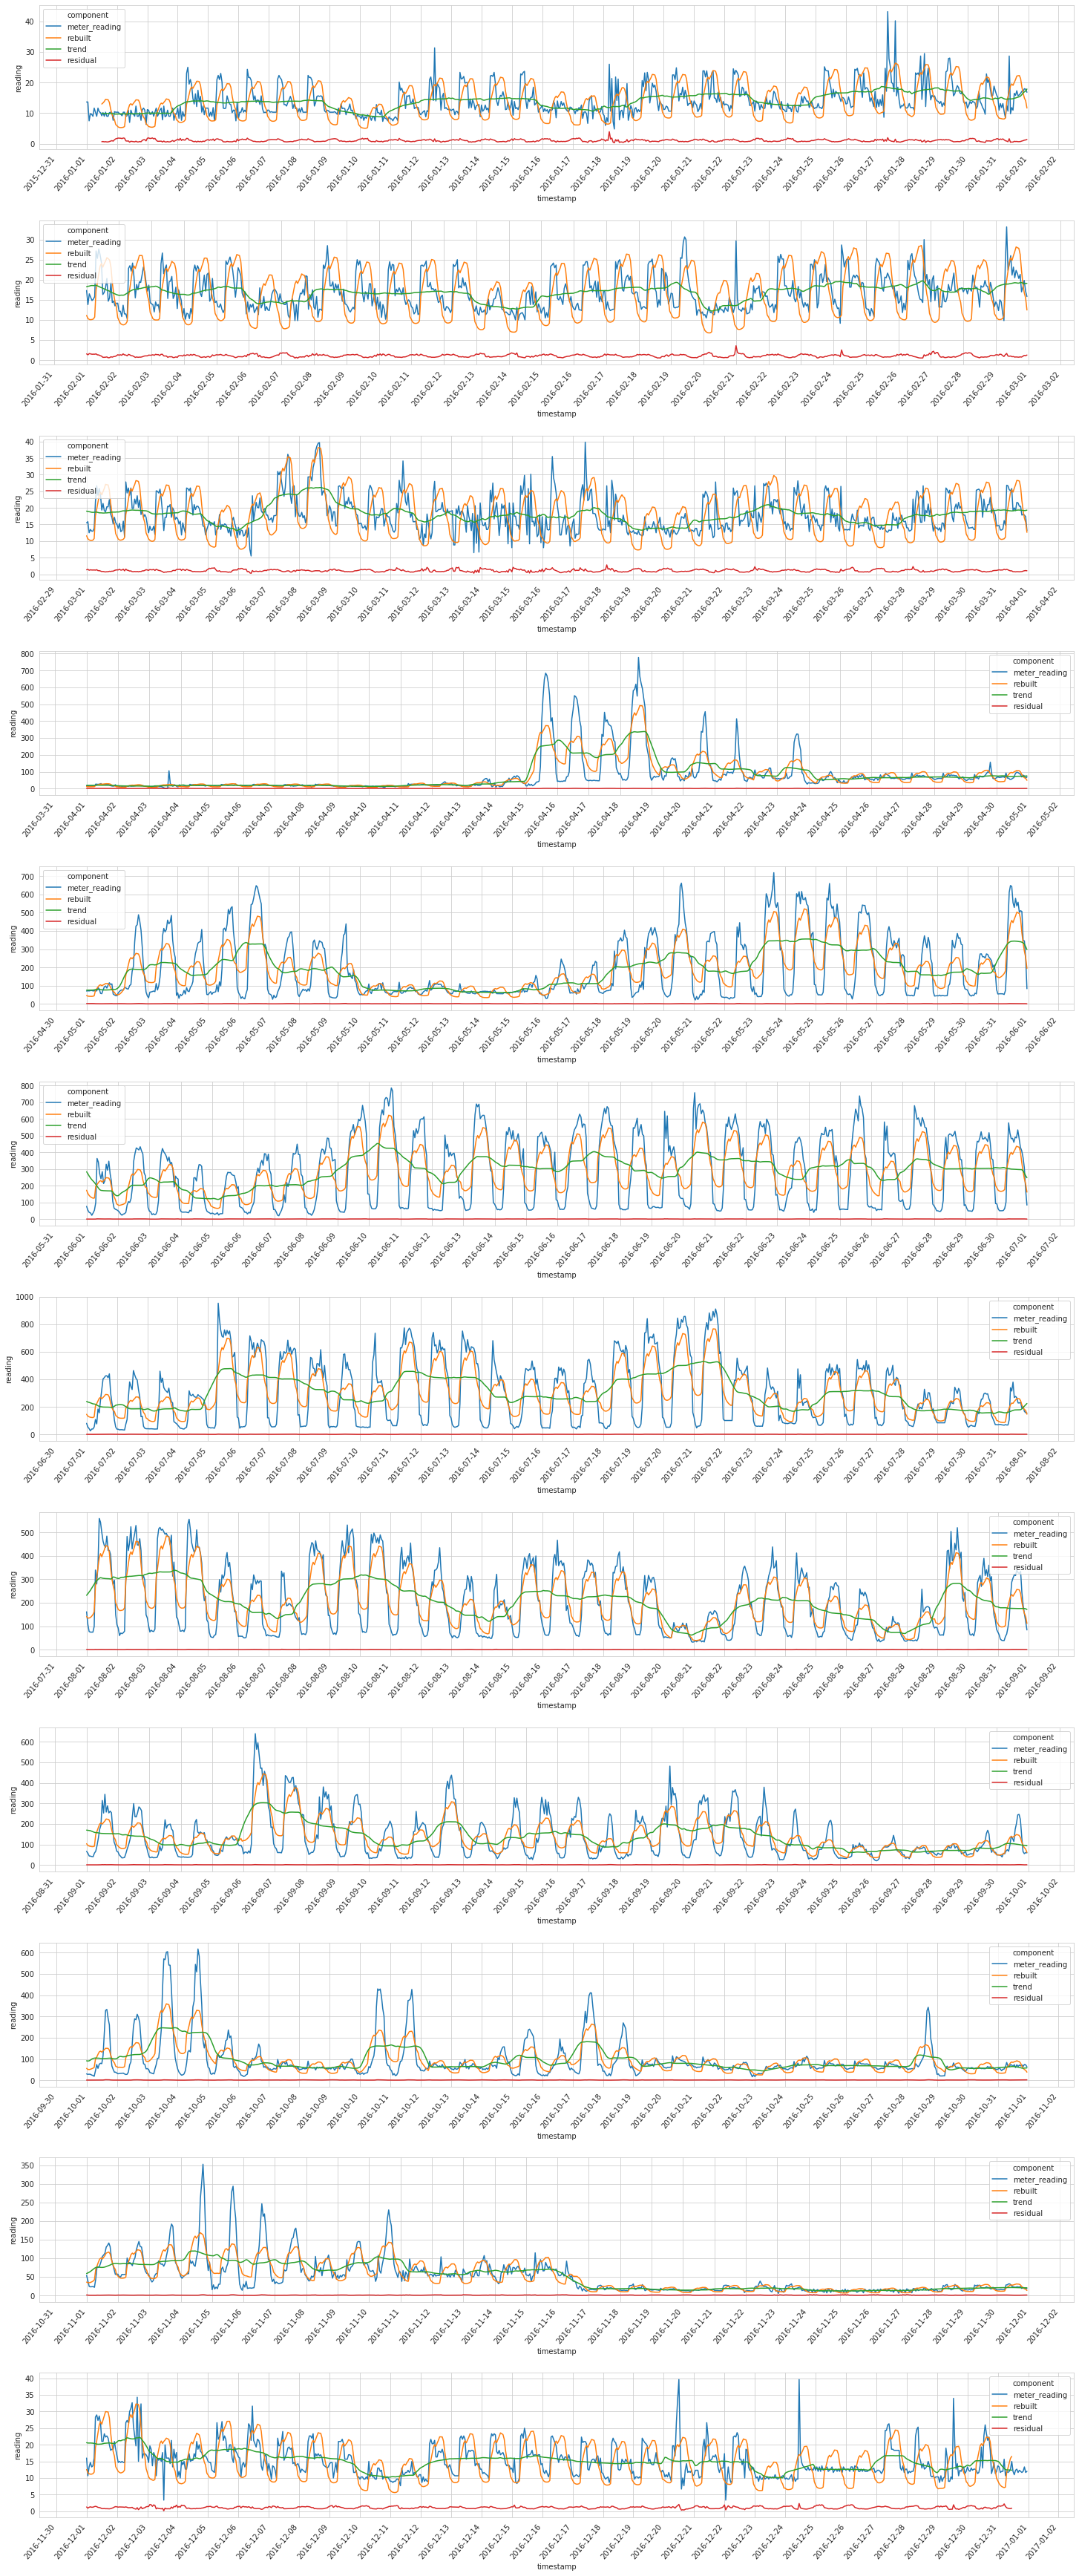

In [52]:
# Plot month by month

date_range = pd.date_range(
    start=df_meters.index.min()-pd.Timedelta('1 hours'), 
    end=df_meters.index.max(), 
    freq='1M'
)

fig = plt.figure(figsize=(20, 4*(date_range.shape[0]-1)))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(df_decomposed_readings, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

Note : it might be interesting to add residuals as a target variable for feature indentification.

In [53]:
# Add trend and residuals to df_features
df_features['meter_reading_trend'] = res.trend
df_features['meter_reading_resid'] = res.resid

In [54]:
df_features.head()

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_hour,day_of_week,meter_reading_trend,meter_reading_resid
timestamp,,,,,,,,,,,
2016-01-01 00:00:00,13.6612,-8.3,-12.2,NaN,1023.3,250.0,4.1,0,4,NaN,NaN
2016-01-01 01:00:00,13.6612,-8.3,-11.7,-1.0,1023.3,240.0,4.1,1,4,NaN,NaN
2016-01-01 02:00:00,7.4970,-7.8,-11.1,-1.0,1022.9,240.0,3.1,2,4,NaN,NaN
2016-01-01 03:00:00,9.8294,-7.8,-11.1,-1.0,1022.7,250.0,4.1,3,4,NaN,NaN
2016-01-01 04:00:00,9.6628,-7.2,-10.6,0.0,1022.8,270.0,4.1,4,4,NaN,NaN


In [55]:
# Add lagged ts : 1h, 2h, 5h, 10h

In [62]:
features_to_shift = set(df_weather.columns).intersection(set(df_features.columns))
features_to_shift

{'air_temperature',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed'}

In [63]:
shifts = [1, 2, 5, 10]

for c in features_to_shift:
    ts = df_features[c]
    for shift in shifts:
        shifted_ts = ts.shift(periods=shift, freq='1H')
        new_col_name = '' + c + '_shift_' + str(shift) + 'H'
        df_features[new_col_name] = shifted_ts

In [64]:
df_features.head()

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_hour,day_of_week,meter_reading_trend,...,air_temperature_shift_5H,air_temperature_shift_10H,sea_level_pressure_shift_1H,sea_level_pressure_shift_2H,sea_level_pressure_shift_5H,sea_level_pressure_shift_10H,precip_depth_1_hr_shift_1H,precip_depth_1_hr_shift_2H,precip_depth_1_hr_shift_5H,precip_depth_1_hr_shift_10H
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,13.6612,-8.3,-12.2,NaN,1023.3,250.0,4.1,0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,13.6612,-8.3,-11.7,-1.0,1023.3,240.0,4.1,1,4,NaN,...,NaN,NaN,1023.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,7.4970,-7.8,-11.1,-1.0,1022.9,240.0,3.1,2,4,NaN,...,NaN,NaN,1023.3,1023.3,NaN,NaN,-1.0,NaN,NaN,NaN
2016-01-01 03:00:00,9.8294,-7.8,-11.1,-1.0,1022.7,250.0,4.1,3,4,NaN,...,NaN,NaN,1022.9,1023.3,NaN,NaN,-1.0,-1.0,NaN,NaN
2016-01-01 04:00:00,9.6628,-7.2,-10.6,0.0,1022.8,270.0,4.1,4,4,NaN,...,NaN,NaN,1022.7,1022.9,NaN,NaN,-1.0,-1.0,NaN,NaN


In [65]:
df_features.columns

Index(['meter_reading', 'air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'day_hour', 'day_of_week', 'meter_reading_trend',
       'meter_reading_resid', 'wind_speed_shift_1H', 'wind_speed_shift_2H',
       'wind_speed_shift_5H', 'wind_speed_shift_10H',
       'dew_temperature_shift_1H', 'dew_temperature_shift_2H',
       'dew_temperature_shift_5H', 'dew_temperature_shift_10H',
       'wind_direction_shift_1H', 'wind_direction_shift_2H',
       'wind_direction_shift_5H', 'wind_direction_shift_10H',
       'air_temperature_shift_1H', 'air_temperature_shift_2H',
       'air_temperature_shift_5H', 'air_temperature_shift_10H',
       'sea_level_pressure_shift_1H', 'sea_level_pressure_shift_2H',
       'sea_level_pressure_shift_5H', 'sea_level_pressure_shift_10H',
       'precip_depth_1_hr_shift_1H', 'precip_depth_1_hr_shift_2H',
       'precip_depth_1_hr_shift_5H', 'precip_depth_1_hr_shift_10H'],
      dtype='obje

In [66]:
# Now let's add averaged features

In [67]:
timeframes = [4, 24, 72]
features_to_avg = features_to_shift.copy()
features_to_avg.remove('wind_direction')
do_center = False

for c in features_to_avg:
    ts = df_features[c]
    for timeframe in timeframes:
        shifted_ts = ts.rolling(timeframe, center=do_center).mean()
        new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
        df_features[new_col_name] = shifted_ts

In [68]:
df_features.columns

Index(['meter_reading', 'air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'day_hour', 'day_of_week', 'meter_reading_trend',
       'meter_reading_resid', 'wind_speed_shift_1H', 'wind_speed_shift_2H',
       'wind_speed_shift_5H', 'wind_speed_shift_10H',
       'dew_temperature_shift_1H', 'dew_temperature_shift_2H',
       'dew_temperature_shift_5H', 'dew_temperature_shift_10H',
       'wind_direction_shift_1H', 'wind_direction_shift_2H',
       'wind_direction_shift_5H', 'wind_direction_shift_10H',
       'air_temperature_shift_1H', 'air_temperature_shift_2H',
       'air_temperature_shift_5H', 'air_temperature_shift_10H',
       'sea_level_pressure_shift_1H', 'sea_level_pressure_shift_2H',
       'sea_level_pressure_shift_5H', 'sea_level_pressure_shift_10H',
       'precip_depth_1_hr_shift_1H', 'precip_depth_1_hr_shift_2H',
       'precip_depth_1_hr_shift_5H', 'precip_depth_1_hr_shift_10H',
       'air_temper

In [69]:
df_features.head()

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_hour,day_of_week,meter_reading_trend,...,sea_level_pressure_ma_72H,precip_depth_1_hr_ma_4H,precip_depth_1_hr_ma_24H,precip_depth_1_hr_ma_72H,wind_speed_ma_4H,wind_speed_ma_24H,wind_speed_ma_72H,dew_temperature_ma_4H,dew_temperature_ma_24H,dew_temperature_ma_72H
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,13.6612,-8.3,-12.2,NaN,1023.3,250.0,4.1,0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,13.6612,-8.3,-11.7,-1.0,1023.3,240.0,4.1,1,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,7.4970,-7.8,-11.1,-1.0,1022.9,240.0,3.1,2,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,9.8294,-7.8,-11.1,-1.0,1022.7,250.0,4.1,3,4,NaN,...,NaN,NaN,NaN,NaN,3.85,NaN,NaN,-11.525,NaN,NaN
2016-01-01 04:00:00,9.6628,-7.2,-10.6,0.0,1022.8,270.0,4.1,4,4,NaN,...,NaN,-0.75,NaN,NaN,3.85,NaN,NaN,-11.125,NaN,NaN


We have our features matrix. Now let's see which features have some meaning.<br>
We use the F-test to measure statistical significance of features.

In [70]:
y = df_features['meter_reading_trend']

In [71]:
x_feats = df_features.columns.to_list()
x_feats.remove('meter_reading')
x_feats.remove('meter_reading_trend')
x_feats.remove('meter_reading_resid')
x_feats
X = df_features[x_feats]

In [72]:
# We need "clean" features, with no NaNs, to use SelectKBest

In [73]:
df_features_clean = df_features[~df_features['meter_reading_trend'].isna()].copy()
df_features_clean.drop(['meter_reading', 'meter_reading_resid'], axis=1, inplace=True)

In [74]:
df_features.shape

(8784, 50)

In [75]:
df_features_clean.shape

(8760, 48)

In [76]:
df_features_clean.isna().sum()

air_temperature                    2
dew_temperature                    2
precip_depth_1_hr                 12
sea_level_pressure               121
wind_direction                   218
wind_speed                         2
day_hour                           0
day_of_week                        0
meter_reading_trend                0
wind_speed_shift_1H                2
wind_speed_shift_2H                2
wind_speed_shift_5H                2
wind_speed_shift_10H               2
dew_temperature_shift_1H           2
dew_temperature_shift_2H           2
dew_temperature_shift_5H           2
dew_temperature_shift_10H          2
wind_direction_shift_1H          218
wind_direction_shift_2H          218
wind_direction_shift_5H          218
wind_direction_shift_10H         217
air_temperature_shift_1H           2
air_temperature_shift_2H           2
air_temperature_shift_5H           2
air_temperature_shift_10H          2
sea_level_pressure_shift_1H      121
sea_level_pressure_shift_2H      121
s

In [77]:
# Drop features with to much NaNs

#precip_depth_1_hr_ma_72H         297
#sea_level_pressure_ma_4H         442
#sea_level_pressure_ma_24H       2014
#sea_level_pressure_ma_72H       4590

#wind_direction_shift_1H          221
#wind_direction_shift_2H          223
#wind_direction_shift_5H          229
#wind_direction_shift_10H         235

#air_temperature_ma_72H           215
#dew_temperature_ma_72H           215

to_drop=[
'precip_depth_1_hr_ma_72H', 
'sea_level_pressure_ma_4H' ,
'sea_level_pressure_ma_24H',
'sea_level_pressure_ma_72H',
'wind_direction_shift_1H',
'wind_direction_shift_2H',
'wind_direction_shift_5H',
'wind_direction_shift_10H',
'air_temperature_ma_72H',
'dew_temperature_ma_72H']

df_features_clean.drop(to_drop, axis=1, inplace=True)
df_features_clean.isna().sum()

air_temperature                   2
dew_temperature                   2
precip_depth_1_hr                12
sea_level_pressure              121
wind_direction                  218
wind_speed                        2
day_hour                          0
day_of_week                       0
meter_reading_trend               0
wind_speed_shift_1H               2
wind_speed_shift_2H               2
wind_speed_shift_5H               2
wind_speed_shift_10H              2
dew_temperature_shift_1H          2
dew_temperature_shift_2H          2
dew_temperature_shift_5H          2
dew_temperature_shift_10H         2
air_temperature_shift_1H          2
air_temperature_shift_2H          2
air_temperature_shift_5H          2
air_temperature_shift_10H         2
sea_level_pressure_shift_1H     121
sea_level_pressure_shift_2H     121
sea_level_pressure_shift_5H     121
sea_level_pressure_shift_10H    121
precip_depth_1_hr_shift_1H       12
precip_depth_1_hr_shift_2H       12
precip_depth_1_hr_shift_5H  

In [87]:
na_rows = df_features_clean.isna().sum(axis=1)

In [88]:
# 1002 rows with a null value
na_rows[na_rows > 0].count()

0

In [89]:
df_features_clean.shape

(7772, 38)

In [90]:
# drop rows with NaNs
df_features_clean.dropna(axis=0, how='any', inplace=True)
df_features_clean.shape

(7772, 38)

In [91]:
y = df_features_clean['meter_reading_trend']

In [92]:
x_feats = df_features_clean.columns.to_list()
x_feats.remove('meter_reading_trend')
x_feats
X = df_features_clean[x_feats]

In [93]:
# Compute F-test statistics.

selector = SelectKBest(f_regression, k='all')
X_new = selector.fit_transform(X, y)

In [94]:
# Display p-values nicely

f_data = {'feature' : x_feats, 'p_value' : selector.pvalues_.tolist()}
df_pvals = pd.DataFrame(data=f_data).sort_values(by='p_value').set_index('feature')
df_pvals

,p_value
feature,
air_temperature,0.000000e+00
air_temperature_ma_24H,0.000000e+00
air_temperature_ma_4H,0.000000e+00
air_temperature_shift_10H,0.000000e+00
dew_temperature_ma_4H,0.000000e+00
air_temperature_shift_2H,0.000000e+00
air_temperature_shift_1H,0.000000e+00
dew_temperature_shift_10H,0.000000e+00
dew_temperature_shift_5H,0.000000e+00


In [95]:
# Keep only features with 5% significance
df_pvals[df_pvals['p_value'] < .05]

,p_value
feature,
air_temperature,0.000000e+00
air_temperature_ma_24H,0.000000e+00
air_temperature_ma_4H,0.000000e+00
air_temperature_shift_10H,0.000000e+00
dew_temperature_ma_4H,0.000000e+00
air_temperature_shift_2H,0.000000e+00
air_temperature_shift_1H,0.000000e+00
dew_temperature_shift_10H,0.000000e+00
dew_temperature_shift_5H,0.000000e+00


In [96]:
# We have some obvious redundancies, for instance all features built from dew temperature are significants.
# We keep only features with the lowest p-values when we have redundancies.
# We keep :
selected_features = ['day_of_week', 'dew_temperature_ma_24H', 'air_temperature', 'wind_speed_ma_24H', 
                'precip_depth_1_hr_ma_24H', 'sea_level_pressure_shift_10H']

# (Exception for wind speed : we prefer 'wind_speed_ma_24H' to 'wind_speed_ma_72H' because it has less NaNs)

# Features not kept : wind_direction and day_hour.
# day_hour not kept means the one-day seasonal component has been correctly picked up by the 
# seasonal/trend decomposition

df_selected_features = df_features_clean[selected_features]

Now, let's look at correlations.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5]), <a list of 38 Text xticklabel objects>)

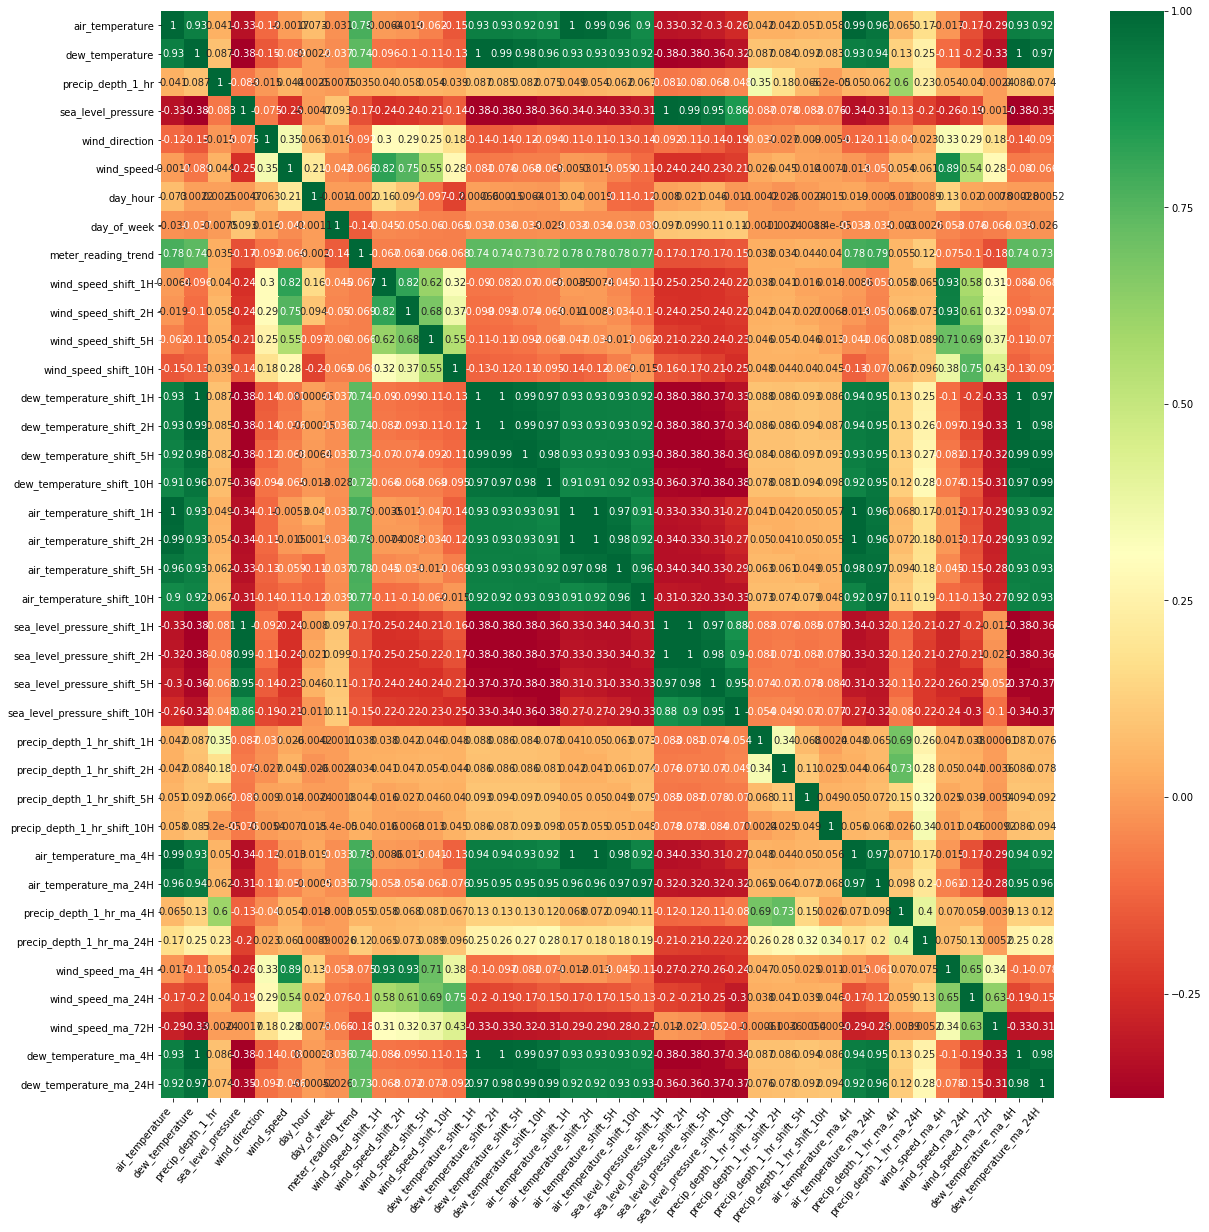

In [97]:
# Correlation matrix for all features.
# Features derived from the same data are obviously highly correlated.

correlations = df_features_clean.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlations, annot=True, cmap="RdYlGn")
plt.xticks(rotation=50, horizontalalignment='right')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text xticklabel objects>)

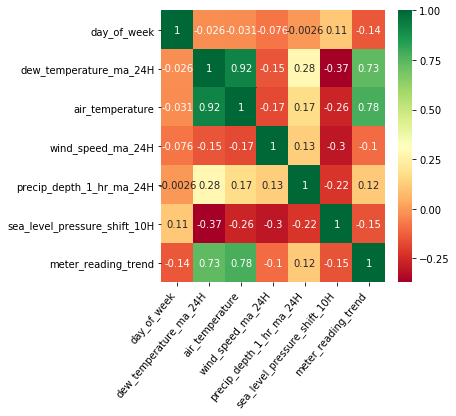

In [98]:
# Correlation matrix for selected features.

correlations = df_features_clean[selected_features+['meter_reading_trend']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlations, annot=True, cmap="RdYlGn")
plt.xticks(rotation=50, horizontalalignment='right')

We observe that 'air_temperature' and 'dew_temperature_ma_24H' are highly correlated (0.92).
'sea_level_pressure_shift_10H' has correlations ~0.3 with other meteorological features.<br>
As we already has a small number of features, and also because some features have a different temporal horizon, which can be interesting, we can afford to keep all those remaining features nonetheless.

In [99]:
# Let's save df_features_clean as intermediate data for further studies.

save_features_clean = False
if save_features_clean :
    df_features_clean[selected_features+['meter_reading_trend']].to_csv('../../data/intermediate/building_1176/features_clean_1176.csv')